In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import numpy as np
import pytz
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore", message="The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.")

# Introducción

El siguiente código se estructura de la siguiente manera:

1. Se extraen los datos tal cual de los CSV (datos de precipitaciones, niveles históricos, etc). Faltarían datos de consumo de agua.
2. Se crea el objecto *MercadoDiario*, que permite acceder a métodos en tiempo real e históricos para demanda y precio de la energía
3. Se define el objecto *ModeloPresa*, que representa una presa particular con una cierta configuración física (nombre, volumen máximo, caudal de desagüe, etc), y se crean todos los objetos correspondientes a nuestras presas. Faltaría una de las presas pequeñas que nunca consigo encontrar datos.
4. se define el objecto *SimulacionPresa*, que representa la simulación de una presa a medida que va pasando el tiempo, utilizando nuestro modelo de comportamiento.

# Datos precipitaciones

In [ ]:
# Datos históricos de las precipitaciones
pr = pd.read_csv('datos_precipitaciones_2013_2020.csv', sep=',')
pr['FECHA'] = pd.to_datetime(pr['FECHA'], format='%d-%m-%Y')
pr['PRECIPITACION'] = pd.to_numeric(pr['PRECIPITACION'], errors='coerce')

In [ ]:
# Datos en tiempo real de precipitaciones ???

# Datos históricos de embalses

In [ ]:
df = pd.read_csv('datos_embalses_1988_2023.csv', sep=',', usecols=['EMBALSE_NOMBRE', 'FECHA', 'AGUA_ACTUAL'])
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce', format='%m/%d/%y 00:00:00')
df['AGUA_ACTUAL'] = df['AGUA_ACTUAL'].apply(lambda x: float(str(x).replace(',','.')))

# Datos de consumo de agua

In [ ]:
# Datos históricos de consumo de agua

# Datos dinámicos de la red eléctrica

In [ ]:
import requests
import functools
import numpy as np

def medias_por_grupos(lista, longitud_grupos=12):
    grupos = [lista[i:i+longitud_grupos] for i in range(0, len(lista), longitud_grupos)]
    medias = [np.mean(grupo) for grupo in grupos]
    return medias

In [ ]:
dp = pd.read_csv('datos_precio_electricidad_2014_2023.csv', sep=',')
dp['FECHA'] = pd.to_datetime(dp['FECHA'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%f%z', utc=True).dt.tz_localize(None)
dp['PRECIO'] = pd.to_numeric(dp['PRECIO'], errors='coerce')
dp = dp.drop_duplicates()
dp.set_index('FECHA', inplace=True)

In [ ]:
class MercadoDiario:
    def __init__(self):
        pass
    
    # Devuelve los precios del Mercado Diario hora a hora.
    # Se devuelven 24 valores si sólo se especifica un día,
    # o más si se indica un rango de días con "hasta".
    # @functools.lru_cache()
    @functools.lru_cache()
    def get_precios_dia(self, desde=datetime(2023, 3, 23, hour=1), hasta=None):
        hasta = datetime(desde.year,desde.month,desde.day, hour=23) if hasta is None else hasta
        
        # Si la hora límite es 00:00, moverlo a las 23:00 del día
        # anterior para evitar situaciones extrañas
        if hasta.hour == 0 and hasta.minute == 0:
            hasta = hasta - timedelta(hours=1)
        
        try:
            # Tratar de cargar los precios de la tabla de datos históricos
            # si es posible; si no, cargar datos dinámicos.
            lista = list(dp.loc[desde:hasta]['PRECIO'].values)
            if lista == []:
                # Si está vacío preguntar al día anterior
                desde = desde + timedelta(days=-1)
                hasta = hasta + timedelta(days=-1)
                return self.get_precios_dia(desde, hasta)
            else:
                return list(dp.loc[desde:hasta]['PRECIO'].values)
        except:   
            a = desde.strftime('%Y-%m-%dT%H:%M')  
            b = a if hasta is None else hasta.strftime('%Y-%m-%dT%H:%M')
            URL = f'https://apidatos.ree.es/es/datos/mercados/precios-mercados-tiempo-real?start_date={a}&end_date={b}&time_trunc=hour'
            response = requests.get(URL)
            json_object = response.json()
            json_precios = json_object["included"][0]["attributes"]["values"]
            precios = list(map(lambda x: x["value"], json_precios))

            return precios
    
    # Devuelve la demanda programada del día por el Mercado Diario, 
    # hora a hora. Si se establece la variable "hasta", se devuelve
    # la demanda de un rango de dias.
    @functools.lru_cache()
    def get_demanda_programada_dia(self, desde=date(2023, 3, 23), hasta=None):
        a = desde.strftime('%Y-%m-%d')
        b = a if hasta is None else hasta.strftime('%Y-%m-%d')
        URL = f'https://apidatos.ree.es/es/datos/demanda/demanda-tiempo-real?start_date={a}T00:00&end_date={b}T23:59&time_trunc=hour'
        response = requests.get(URL)
        json_object = response.json()
        for x in json_object["included"]:
            if x["type"] == "Demanda programada":
                json_demanda = x["attributes"]["values"]
                demanda = list(map(lambda x: x["value"], json_demanda))
                # La demanda está programada cada 5 minutos, por lo que 12 por hora.
                # Nosotros por facilidad tomamos la media de cada hora.
                return medias_por_grupos(demanda, 12)
    
    # Función principal del Mercado Diario.
    # Para una función de coste y tiempo dato (especificado con datetime),
    # se nos indica la potencia aprobada para generar, en MW.
    def potencia_aprobada(self, potencia_maxima, coste, t1, t2=None):
        precios = self.get_precios_dia(t1, t2)
        return list(map(lambda precio: potencia_maxima if coste <= precio else 0, precios))

In [ ]:
mercadoDiario = MercadoDiario()

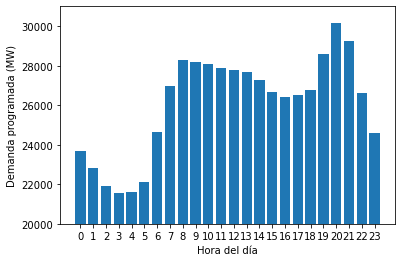

In [ ]:
import matplotlib.pyplot as plt

demandas = mercadoDiario.get_demanda_programada_dia(date(2023, 3, 24))
plt.bar(range(len(demandas)), demandas)
plt.xticks(range(len(demandas)))
plt.xlabel('Hora del día')
plt.ylabel('Demanda programada (MW)')
plt.ylim(20000, 31000)
# plt.savefig('graficos/curva-consumo.png', dpi=300, bbox_inches='tight')
plt.show()

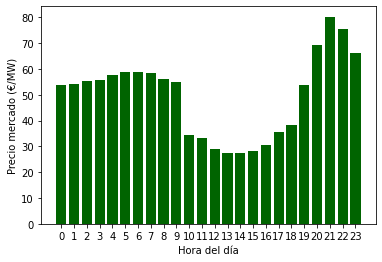

In [ ]:
precios = mercadoDiario.get_precios_dia(datetime(2023, 4, 2))
plt.bar(range(len(precios)), precios, color="darkgreen")
plt.xticks(range(len(precios)))
plt.xlabel('Hora del día')
plt.ylabel('Precio mercado (€/MW)')
# plt.savefig('graficos/curva-precio.png', dpi=300, bbox_inches='tight')
plt.show()

# Simulación del Mercado Diario

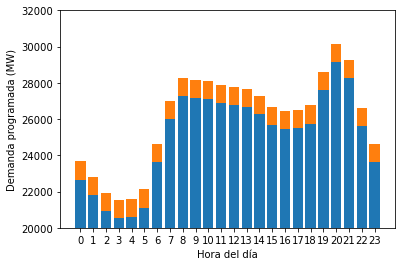

In [ ]:
# Coste de operación en €/MW
coste_operacion = 2
# Potencia máxima de generación
potencia_maxima = 1000

energia_producida = mercadoDiario.potencia_aprobada(
    potencia_maxima, 
    coste_operacion, 
    datetime(2023, 4, 2))

_demandas = [x-y for (x,y) in zip(demandas, energia_producida)]
plt.bar(range(len(_demandas)), _demandas)
plt.bar(range(len(energia_producida)), energia_producida, bottom=_demandas)
plt.xticks(range(len(_demandas)))
plt.xlabel('Hora del día')
plt.ylabel('Demanda programada (MW)')
plt.ylim(20000, 32000)
# plt.savefig('graficos/ejemplo-produccion-avariciosa.png', dpi=300, bbox_inches='tight')
plt.show()

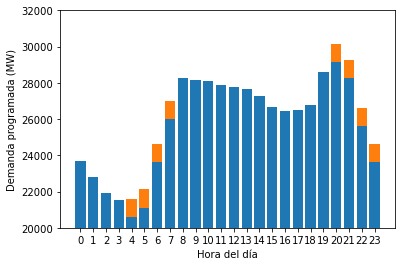

In [ ]:
# Coste de operación en €/MW
coste_operacion = 2
# Coste de correción
coste_correcion = 55
# Potencia máxima de generación
potencia_maxima = 1000

energia_producida = mercadoDiario.potencia_aprobada(
    potencia_maxima, 
    coste_operacion+coste_correcion, 
    datetime(2023, 4, 2))

_demandas = [x-y for (x,y) in zip(demandas, energia_producida)]
plt.bar(range(len(_demandas)), _demandas)
plt.bar(range(len(energia_producida)), energia_producida, bottom=_demandas)
plt.xticks(range(len(_demandas)))
plt.xlabel('Hora del día')
plt.ylabel('Demanda programada (MW)')
plt.ylim(20000, 32000)
# plt.savefig('graficos/ejemplo-produccion-conservadora.png', dpi=300, bbox_inches='tight')
plt.show()

# Modelo de la presa

In [ ]:
class ModeloPresa:
    # Crea una nueva presa con las siguientes propiedades:
    #   * nombre: nombre del embalse que contiene
    #   * vmax: volumen máximo de capacidad (hm3)
    #   * cmax: caudal máximo de desagüe (m3/s)
    #   * pmax: potencia máxima de generación (MW)
    #   * coste_op: coste constante de operación
    def __init__(self, nombre, vmax, cmax, pmax, coste_op=5):
        self.nombre = nombre
        self.vmax = vmax
        self.cmax = cmax
        self.pmax = pmax
        self.coste_op = coste_op
    
    # Devuelve los niveles históricos del embalse en hm3.
    # Se utilizan los datos tal cual, que tienen medidas en intervalos irregulares.
    # Con "freq" se puede normalizar a medidas regulares:
    #    * 'D': cada día
    #    * 'W': cada semana
    #    * 'M': cada mes
    #    * 'Y': cada año
    def niveles_historicos(self, freq=None):
        niveles = df[df['EMBALSE_NOMBRE'] == self.nombre][["FECHA", "AGUA_ACTUAL"]]
        niveles.set_index('FECHA', inplace=True)
        if (freq):
            inicio = df['FECHA'].min()
            fin = df['FECHA'].max()
            idx = pd.date_range(inicio, fin, freq=freq)
            niveles = niveles.reindex(idx, method='nearest')
        return niveles.clip(0.0, self.vmax)
    
    # Como niveles_historicos(), pero devuelve los datos en una tabla 2D,
    # con una fila por año de datos.
    def niveles_historicos_por_anho(self, freq='D'):
        datos_dias = pd.DataFrame()
        datos_dias.index.name = 'AÑO'

        niveles = self.niveles_historicos(freq=freq)
        for anho, datos_anho in niveles.groupby(niveles.index.year):
            # Saltarnos el primer año, porque está casi incompleto
            # y nos estropea el mecanismo de crear la tabla
            if anho == 1987: continue

            def reindex(fechas):
                if freq == 'D':
                    return fechas.dayofyear
                if freq == 'W':
                    return fechas.weekofyear
                if freq == 'M':
                    return fechas.month
            datos_anho.index = datos_anho.index.map(reindex)

            datos_anho = datos_anho.T.loc['AGUA_ACTUAL']
            datos_anho.name = anho

            datos_dias = datos_dias.append(datos_anho)
        return datos_dias
    
    # Devuelve los niveles históricos del embalse como un porcentaje de su capacidad.
    def niveles_relativos_historicos(self, freq=None):
        return  self.niveles_historicos(freq=freq).apply(lambda nivel: nivel/self.vmax)
    
    # Devuelve los niveles históricos del embalse como un porcentaje de su capacidad.
    def niveles_relativos_historicos_por_anho(self, freq=None):
        return  self.niveles_historicos_por_anho(freq=freq).apply(lambda nivel: nivel/self.vmax)
    
    # Devuelve los niveles históricos de precipitaciones 
    def precipitaciones_historicas(self, freq=None):
        precipitaciones = pr[pr['EMBALSE_NOMBRE'] == self.nombre][['FECHA', 'PRECIPITACION']]
        precipitaciones.set_index('FECHA', inplace=True)
        if (freq):
            precipitaciones = precipitaciones.reset_index()
            precipitaciones = precipitaciones.groupby(pd.Grouper(key='FECHA', freq=freq)).sum()
        return precipitaciones
    
    def precipitaciones_historicas_por_anho(self, freq='D'):
        datos_dias = pd.DataFrame()
        datos_dias.index.name = 'AÑO'

        niveles = self.precipitaciones_historicas(freq=freq)
        for anho, datos_anho in niveles.groupby(niveles.index.year):
            # Saltarnos el primer año, porque está casi incompleto
            # y nos estropea el mecanismo de crear la tabla
            if anho == 2013: continue

            def reindex(fechas):
                if freq == 'D':
                    return fechas.dayofyear
                if freq == 'W':
                    return fechas.weekofyear
                if freq == 'M':
                    return fechas.month
            datos_anho.index = datos_anho.index.map(reindex)

            datos_anho = datos_anho.T.loc['PRECIPITACION']
            datos_anho.name = anho

            datos_dias = datos_dias.append(datos_anho)
        return datos_dias
    
    # Nuestro factor de conversión de energia (MWh) a agua (m3)
    def k(self):
        return (self.cmax * 3_600) / (self.pmax)
    
    # Devuelve un array de tramos del mercado diarío, y la potencia que se 
    # aprobó para producir en cada uno de ellos, desde t1 hasta t2, o 
    # durante todo el día si t2 es None.
    # Se utiliza un determinado coste de correción para el coste ofrecido
    # en el mercado diario.
    def potencia_aprobada(self, t1, t2=None, coste_correcion=0.0):
        coste = self.coste_op + coste_correcion
        return mercadoDiario.potencia_aprobada(self.pmax, coste, t1, t2)

In [ ]:
aldeadavila = ModeloPresa("Aldeadávila", vmax=114, cmax=333, pmax=1243)
alcantara = ModeloPresa("Alcántara", vmax=3162, cmax=677, pmax=957)
villarino = ModeloPresa("Almendra", vmax=2413, cmax=None, pmax=857)
cortes = ModeloPresa("Cortes II", vmax=118, cmax=600, pmax=630)
saucelle = ModeloPresa("Saucelle", vmax=182, cmax=194, pmax=520)
cedillo = ModeloPresa("Cedillo", vmax=260, cmax=504, pmax=500)
sallente = ModeloPresa("Sallente", vmax=6, cmax=36, pmax=468)
# Central de Tajo de la Encantada; no hay datos
aguayo = ModeloPresa("Alsa - Mediajo", vmax=22, cmax=1, pmax=360)
mequinenza = ModeloPresa("Mequinenza", vmax=1530, cmax=160, pmax=324)
luna = ModeloPresa("Barrios de Luna", vmax=308, cmax=100, pmax=80)

In [ ]:
presas = {
    "Aldeadávila": aldeadavila,
    "Alcántara": alcantara,
    "Villarino": villarino,
    "Cortes-La Muela": cortes,
    "Saucelle": saucelle,
    "Cedillo": cedillo,
    "Estany-Gento Sallente": sallente,
    "Aguayo": aguayo,
    "Mequinenza": mequinenza,
    "Mora de Luna": luna
}

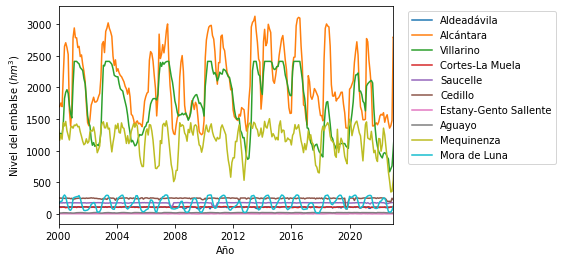

In [ ]:
for nombre, presa in presas.items():
    niveles = presa.niveles_historicos(freq='M')
    plt.plot(niveles.index, niveles.values, label=nombre)    
plt.xlabel('Año')
plt.ylabel('Nivel del embalse ($hm^3$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xlim(date(2000, 1, 1), date(2023, 1, 1))
# plt.savefig('graficos/niveles-embalses.png', dpi=300, bbox_inches='tight')
plt.show()

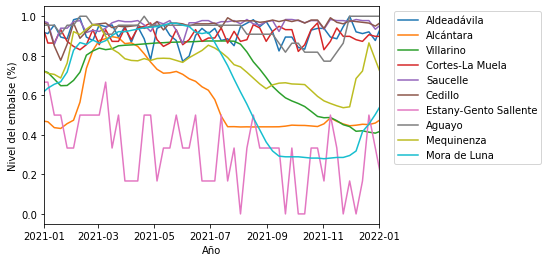

In [ ]:
for nombre, presa in presas.items():
    niveles = presa.niveles_relativos_historicos()
    plt.plot(niveles.index, niveles.values, label=nombre)    
plt.xlabel('Año')
plt.ylabel('Nivel del embalse (%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xlim(date(2021, 1, 1), date(2022, 1, 1))
# plt.savefig('graficos/niveles-embalses.png', dpi=300, bbox_inches='tight')
plt.show()

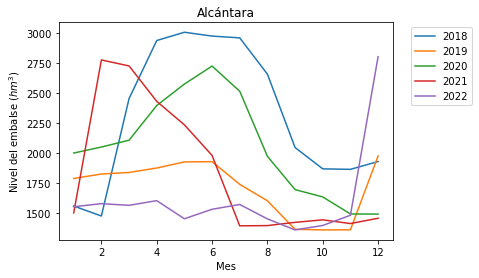

In [ ]:
niveles = alcantara.niveles_historicos_por_anho(freq='M')
niveles.loc[2018:2022].T.plot()
plt.xlabel('Mes')
plt.ylabel('Nivel del embalse ($hm^3$)')
plt.title('Alcántara')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
# plt.savefig('graficos/niveles-alcantara.png', dpi=300, bbox_inches='tight')
plt.show()

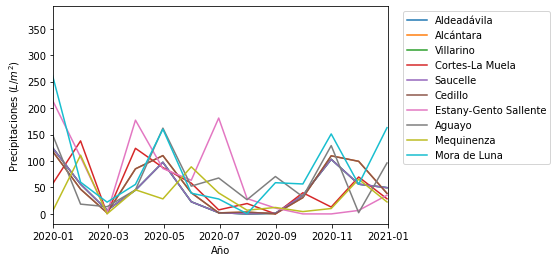

In [ ]:
for nombre, presa in presas.items():
    niveles = presa.precipitaciones_historicas(freq='M')
    plt.plot(niveles.index, niveles.values, label=nombre)
plt.xlabel('Año')
plt.ylabel('Precipitaciones ($L/m^2$)')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xlim(date(2020, 1, 1), date(2021, 1, 1))
# plt.savefig('graficos/precipitaciones-embalses.png', dpi=300, bbox_inches='tight')
plt.show()

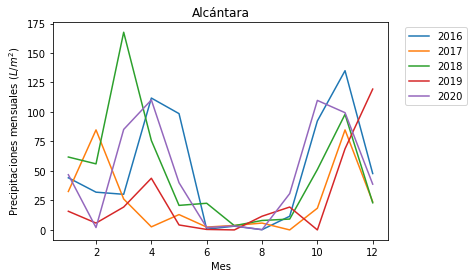

In [ ]:
niveles = alcantara.precipitaciones_historicas_por_anho(freq='M')
niveles.loc[2016:2022].T.plot()
plt.xlabel('Mes')
plt.ylabel('Precipitaciones mensuales ($L/m^2$)')
plt.title('Alcántara')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
# plt.savefig('graficos/precipitaciones-embalses-alcantara.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
niveles.loc[2015].values

array([2341., 2510., 2638., 2767., 2822., 2646., 2435., 2280., 1952.,
       1679., 1589., 1595.])

In [ ]:
np.array(range(1,13))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

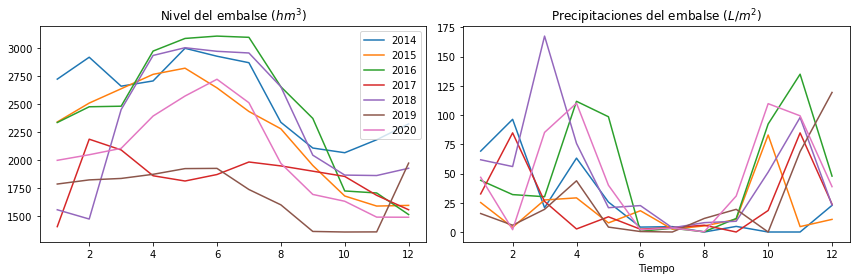

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

niveles = alcantara.niveles_historicos_por_anho(freq='M').loc[2014:2020]
precpts = alcantara.precipitaciones_historicas_por_anho(freq='M').loc[2014:2020]

for year in list(niveles.index):
    axs[0].plot(np.array(range(1,13)), niveles.loc[year].values, label=year)
    axs[1].plot(np.array(range(1,13)), precpts.loc[year].values, label=year)

axs[0].set_title('Nivel del embalse ($hm^3$)')
axs[0].legend(loc='upper right', bbox_to_anchor=(1, 1))
axs[1].set_title('Precipitaciones del embalse ($L/m^2$)')

plt.xlabel('Tiempo')
plt.tight_layout()
# plt.savefig('graficos/niveles-precipitaiones-alcantara.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
xs = np.array(range(1,13))
precpts = alcantara.precipitaciones_historicas_por_anho(freq='M').loc[2014:2020]
ys = precpts.loc[year].values
niveles = alcantara.niveles_historicos_por_anho(freq='M').loc[2014:2020]
zs = niveles.loc[year].values

In [ ]:
ys = np.concatenate([presas[x].precipitaciones_historicas_por_anho(freq='M').loc[2014:2020] for x in presas], axis=0).flatten()
zs = np.concatenate([presas[x].niveles_relativos_historicos_por_anho(freq='M').loc[2014:2020] for x in presas], axis=0).flatten()

In [ ]:
xs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

TypeError: unhashable type: 'Series'

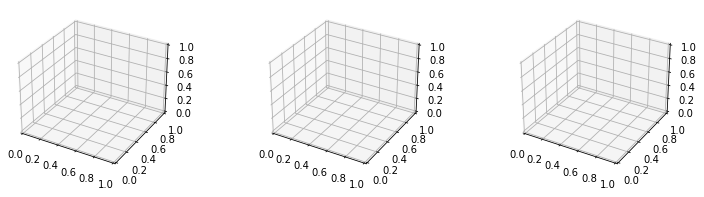

In [ ]:
xs = np.array(range(1,13))
precpts = alcantara.precipitaciones_historicas_por_anho(freq='M').loc[2014:2020]
ys = precpts.loc[year].values
niveles = alcantara.niveles_historicos_por_anho(freq='M').loc[2014:2020]
zs = niveles.loc[year].values

# Regresión lineal
model = LinearRegression()
X = np.column_stack((xs, ys))
model.fit(X, zs)
coef = model.coef_
intercept = model.intercept_

# Plot regresión lineal
x_mesh, y_mesh = np.meshgrid(xs, ys)
z_mesh = coef[0] * x_mesh + coef[1] * y_mesh + intercept

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

for ax, elev, azim in [(ax1, 35, 45), (ax2, 10, 45), (ax3, 10, -60)]:
    ax.scatter(xs, ys, zs, marker='o')

    ax.plot_surface(x_mesh, y_mesh, z_mesh, alpha=0.2)

    ax.set_xlabel('Mes del año')
    ax.set_ylabel('Precipitaciones ($L/m^2$)')
    ax.set_zlabel('Niveles ($hm^3$)')

    ax.view_init(elev=elev, azim=azim)
    
#fig.suptitle('Regresión lineal ')
plt.xlabel('Tiempo')
plt.tight_layout()
# plt.savefig('graficos/intento-regresion-lineal.png', dpi=300, bbox_inches='tight')
plt.show()

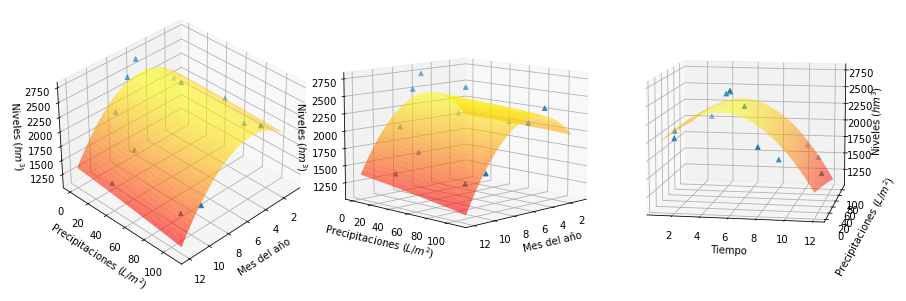

In [ ]:
# Fit polynomial regression with sklearn
degree = 2
poly = PolynomialFeatures(degree)
X = poly.fit_transform(np.column_stack((xs, ys)))
reg = LinearRegression().fit(X, zs)

# Create meshgrid for 3D plot
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                     np.linspace(y_min, y_max, 50))
zz = reg.predict(poly.fit_transform(np.column_stack((xx.ravel(), yy.ravel()))))
zz = zz.reshape(xx.shape)

# Plot the 3D mesh plot
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

for ax, elev, azim in [(ax1, 35, 45), (ax2, 10, 45), (ax3, 10, -80)]:
    ax.plot_surface(xx, yy, zz, cmap='autumn', alpha=0.6)
    ax.scatter(xs, ys, zs, marker='o')

    ax.set_xlabel('Mes del año')
    ax.set_ylabel('Precipitaciones ($L/m^2$)')
    ax.set_zlabel('Niveles ($hm^3$)')

    ax.view_init(elev=elev, azim=azim)
    
plt.xlabel('Tiempo')
plt.tight_layout()
# plt.savefig('graficos/intento-regresion-polinomial.png', dpi=300, bbox_inches='tight')
plt.show()

# Regresión polinómica

In [ ]:
# Utilizar regresión polinómica con precipitaciones_historicas_por_anho()

# Simulación presa

In [ ]:
class SimulacionPresa:
    # Crea una nueva instancia de una presa en ejecución, 
    # empezando en una fecha dada y a un nivel dado.
    # Si no se especifica el nivel, se trata de ver
    # si se conoce el nivel histórico.
    def __init__(self, modelo_presa, fecha, nivel=None):
        self.modelo_presa = modelo_presa
        self.fecha = fecha
        if nivel is None:
            niveles_hist = self.modelo_presa.niveles_historicos(freq='D')
            fecha = date(fecha.year, fecha.month, fecha.day)
            self.nivel = niveles_hist.loc[fecha:fecha].values[0][0]
        else:
            self.nivel = nivel
        self.historial = pd.DataFrame(columns=[
            "NIVEL_SIMULADO", 
            "COSTE_CORRECION",
            "CAUDAL_PRECIPITACIONES", 
            "CAUDAL_CONSUMO", 
            "CAUDAL_EVAPORACION", 
            "CAUDAL_GENERACION"])
    
    # El nivel que tiene la presa actualmente
    def nivel_actual(self):
        return self.nivel
    
    # El nivel que ha tenido la presa a lo largo de su ejecución
    def nivel_historico(self):
        return self.historial
    
    # El volumen de agua que recibe la presa el día actual a razón
    # de precipitaciones, en m3
    def caudal_precipitaciones(self, t1, t2):
        try:
            # Precipitaciones en L/m2
            precp = self.modelo_presa.precipitaciones_historicas().loc[t1:t2].sum()[0]
            # Factor aproximado de los m2 que afectarán al embalse
            precp *= 100_000_000
            # Conversión de L a m3
            precp = precp / 1_000
            return precp
        except:
            return 0
    
    # El volumen de agua que desaparecerá de la presa a raíz de la
    # evaporación natural del agua del embalse.
    def caudal_evaporacion(self, t1, t2):
        days = (t2-t1).days
        return 200_000*days
    
    # El volumen de agua que se consumirá de la presa el día actual
    # a razón de consumo urbano y agrícola, en m3
    def caudal_consumo_agua(self, t1, t2):
        days = (t2-t1).days
        return 10_000*days
    
    # Este es el volumen de agua que tenemos que ajustar en este
    # periodo. Si se devuelve 0, no hay correción, y se genera toda
    # la electricidad posible. Si se devuelve el caudal máximo de
    # agua que se puede desagüar en ese periodo, entonces no se 
    # debería generar nada de electricidad.
    def volumen_ajuste(self, t1, t2):
        hours = (t2-t1).days*24
        
        # Función de prueba utilizando como ajuste el factor de
        # llenado. Teóricamente en vez de esto se utilizarían
        # predicciones en base al mínimo o máximo siguiente.
        factor = self.nivel/self.modelo_presa.vmax
        return self.modelo_presa.cmax*3600*hours*(1.0-factor*factor)
    
    # Este es el coste de correción que se utilizará para el Mercado
    # Diario entre t1 y t2. Se calcula en base a la cantidad de volumen
    # de agua que se tiene que ajustar en este periodo
    def coste_correccion(self, t1, t2):
        volumen_base = self.caudal_consumo_electrico(t1, t2)
        volumen_ajustado = max(volumen_base - self.volumen_ajuste(t1, t2), 0)
        
        # Ir probando distintos valores de correción hasta que
        # encontremos el valor que más nos conviene
        coste_cr_final = 0
        while volumen_base > volumen_ajustado:            
            coste_cr_final += 5
            volumen_base = self.caudal_consumo_electrico(t1, t2, coste_cr_final)
            
        return coste_cr_final
    
    # El volumen de agua que se consumirá de la presa el día actual
    # a razón de generación eléctrica, en m3
    def caudal_consumo_electrico(self, t1, t2, coste_correcion=0.0):
        hours = (t2-t1).days*24
        energia = sum(self.modelo_presa.potencia_aprobada(t1, t2, coste_correcion))
        caudal = energia * self.modelo_presa.k()
        return caudal
    
    def avanzar(self, h=1):        
        siguiente_fecha = self.fecha + timedelta(days=1)
                        
        # Calcular el coste de correción a utilizar
        coste_crr = self.coste_correccion(self.fecha, siguiente_fecha)
        
        # Variaciones en los factores del modelo
        precipitaciones = self.caudal_precipitaciones(self.fecha, siguiente_fecha)
        evaporacion = -self.caudal_evaporacion(self.fecha, siguiente_fecha)
        demanda_agua = -self.caudal_consumo_agua(self.fecha, siguiente_fecha)
        desague_electrico = -self.caudal_consumo_electrico(self.fecha, siguiente_fecha, coste_crr)
                
        # Modificar el nivel (teniendo en cuenta que se mide
        # en hm3, y que está limitado de 0 a Vmax).
        delta_nivel = precipitaciones + evaporacion + demanda_agua + desague_electrico
        self.nivel += delta_nivel / 1_000_000 
        self.nivel = max(min(self.nivel, self.modelo_presa.vmax), 0)
        
        self.fecha = siguiente_fecha
                
        # Guardar el actual en el historial
        self.historial.loc[self.fecha] = {
            "NIVEL_SIMULADO": self.nivel,
            "COSTE_CORRECION": coste_crr,
            "CAUDAL_PRECIPITACIONES": precipitaciones,
            "CAUDAL_CONSUMO": -demanda_agua,
            "CAUDAL_EVAPORACION": -evaporacion,
            "CAUDAL_GENERACION": -desague_electrico
        }

In [ ]:
ejecucion = SimulacionPresa(aldeadavila, datetime(2018, 1, 1))

for i in range(0,360):
    ejecucion.avanzar()

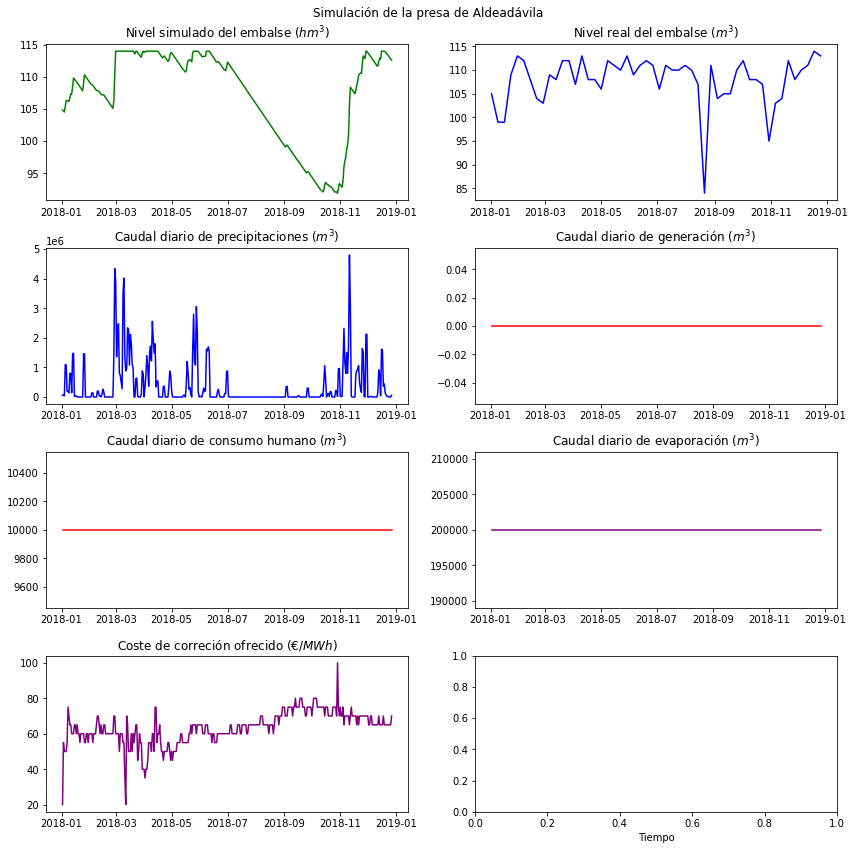

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))

niveles = ejecucion.nivel_historico()
tiempo = niveles.index

inicio = min(tiempo)
fin = max(tiempo)

axs[0][0].plot(tiempo, niveles["NIVEL_SIMULADO"].values, color='green')
axs[0][0].set_title('Nivel simulado del embalse ($hm^3$)')

niveles_reales = ejecucion.modelo_presa.niveles_historicos()[inicio:fin]
axs[0][1].plot(niveles_reales.index, niveles_reales["AGUA_ACTUAL"].values, color='blue')
axs[0][1].set_title('Nivel real del embalse ($m^3$)')

axs[1][0].plot(tiempo, niveles["CAUDAL_PRECIPITACIONES"].values, color='blue')
axs[1][0].set_title('Caudal diario de precipitaciones ($m^3$)')

axs[1][1].plot(tiempo, niveles["CAUDAL_GENERACION"].values, color='red')
axs[1][1].set_title('Caudal diario de generación ($m^3$)')

axs[2][0].plot(tiempo, niveles["CAUDAL_CONSUMO"].values, color='red')
axs[2][0].set_title('Caudal diario de consumo humano ($m^3$)')

axs[2][1].plot(tiempo, niveles["CAUDAL_EVAPORACION"].values, color='purple')
axs[2][1].set_title('Caudal diario de evaporación ($m^3$)')

axs[3][0].plot(tiempo, niveles["COSTE_CORRECION"].values, color='purple')
axs[3][0].set_title('Coste de correción ofrecido ($€/MWh$)')

fig.suptitle('Simulación de la presa de Aldeadávila')
plt.xlabel('Tiempo')
plt.tight_layout()
plt.show()